In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, classification_report
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from matplotlib.pyplot import figure

## Introduction
Given the wide variety of cars manufacturers and car types, it is expected that different cars will command different prices. Luxury cars and high-performance sports cars are often only affordable to a handful of people, whereas regular sedans and SUVs are more affordable to the general public. Here, I hope to create a machine learning regression model that can predict the price of a car given some of its specifications, such as its model, the amount of horsepower it has, and what type of vehicle it is. <br>
The dataset is taken from https://www.kaggle.com/CooperUnion/cardataset.

In [2]:
df = pd.read_csv("data.csv")
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


## Minor Data Cleaning

Before doing anything, I am going to combine the <b>Make</b> and <b>Model</b> of the cars and replace the <b>Model</b> with the combined <b>Make</b> and <b>Model</b>. This is to prevent problems down the road if two different car companies use the same name for their model. Here, I will also replace any NaN values in the <b>Market Category</b> column with empty strings.

In [3]:
df["Model"] = df["Make"] + " " + df["Model"]
df["Market Category"].fillna("", inplace=True)

In [4]:
df.describe(include="all")

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
count,11914,11914,11914.000000,11911,11845.00000,11884.000000,11914,11914,11908.000000,11914,11914,11914,11914.000000,11914.000000,11914.000000,1.191400e+04
unique,48,928,NaN,10,NaN,NaN,5,4,NaN,72,3,16,NaN,NaN,NaN,NaN
top,Chevrolet,Chevrolet Silverado 1500,NaN,regular unleaded,NaN,NaN,AUTOMATIC,front wheel drive,NaN,,Compact,Sedan,NaN,NaN,NaN,NaN
freq,1123,156,NaN,7172,NaN,NaN,8266,4787,NaN,3742,4764,3048,NaN,NaN,NaN,NaN
mean,NaN,NaN,2010.384338,NaN,249.38607,5.628829,NaN,NaN,3.436093,NaN,NaN,NaN,26.637485,19.733255,1554.911197,4.059474e+04
std,NaN,NaN,7.579740,NaN,109.19187,1.780559,NaN,NaN,0.881315,NaN,NaN,NaN,8.863001,8.987798,1441.855347,6.010910e+04
min,NaN,NaN,1990.000000,NaN,55.00000,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,12.000000,7.000000,2.000000,2.000000e+03
25%,NaN,NaN,2007.000000,NaN,170.00000,4.000000,NaN,NaN,2.000000,NaN,NaN,NaN,22.000000,16.000000,549.000000,2.100000e+04
50%,NaN,NaN,2015.000000,NaN,227.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,26.000000,18.000000,1385.000000,2.999500e+04
75%,NaN,NaN,2016.000000,NaN,300.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,30.000000,22.000000,2009.000000,4.223125e+04


Before splitting the data, I will impute the missing values for the <b>Number of Doors</b> column, since those could be easily identified and imputing values there does not affect the rest of the dataset nor the training process. We see that the cars with NaN values for their number of doors are actually known (the Tesla Model S is a 4-door, and the Ferrari is a 2-door). I will impute those here.

In [5]:
df[df["Number of Doors"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
4666,Ferrari,Ferrari FF,2013,premium unleaded (required),651.0,12.0,AUTOMATED_MANUAL,all wheel drive,NaN,"Exotic,High-Performance",Large,Coupe,16,11,2774,295000
6930,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,Performance",Large,Sedan,105,102,1391,79500
6931,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,Performance",Large,Sedan,101,98,1391,66000
6932,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,High-Performance",Large,Sedan,105,92,1391,134500
6933,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,NaN,"Exotic,Performance",Large,Sedan,100,97,1391,74500
6934,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,"Exotic,Performance",Large,Sedan,107,101,1391,71000


In [6]:
df.at[4666, "Number of Doors"] = 2.0
for row_num in range(6930, 6935):
    df.at[row_num, "Number of Doors"] = 4.0

In [7]:
df.describe(include="all")

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
count,11914,11914,11914.000000,11911,11845.00000,11884.000000,11914,11914,11914.000000,11914,11914,11914,11914.000000,11914.000000,11914.000000,1.191400e+04
unique,48,928,NaN,10,NaN,NaN,5,4,NaN,72,3,16,NaN,NaN,NaN,NaN
top,Chevrolet,Chevrolet Silverado 1500,NaN,regular unleaded,NaN,NaN,AUTOMATIC,front wheel drive,NaN,,Compact,Sedan,NaN,NaN,NaN,NaN
freq,1123,156,NaN,7172,NaN,NaN,8266,4787,NaN,3742,4764,3048,NaN,NaN,NaN,NaN
mean,NaN,NaN,2010.384338,NaN,249.38607,5.628829,NaN,NaN,3.436210,NaN,NaN,NaN,26.637485,19.733255,1554.911197,4.059474e+04
std,NaN,NaN,7.579740,NaN,109.19187,1.780559,NaN,NaN,0.881267,NaN,NaN,NaN,8.863001,8.987798,1441.855347,6.010910e+04
min,NaN,NaN,1990.000000,NaN,55.00000,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,12.000000,7.000000,2.000000,2.000000e+03
25%,NaN,NaN,2007.000000,NaN,170.00000,4.000000,NaN,NaN,2.000000,NaN,NaN,NaN,22.000000,16.000000,549.000000,2.100000e+04
50%,NaN,NaN,2015.000000,NaN,227.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,26.000000,18.000000,1385.000000,2.999500e+04
75%,NaN,NaN,2016.000000,NaN,300.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,30.000000,22.000000,2009.000000,4.223125e+04


Now we can split the dataset into a training and testing portion with the target column being <b>MSRP</b>.

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train = train_df.drop(columns=["MSRP"])
y_train = train_df["MSRP"]
X_test = test_df.drop(columns=["MSRP"])
y_test = test_df["MSRP"]

## EDA

We can see that there are still missing values in some columns, such as the columns <b>Engine Fuel Type</b>, <b>Engine HP</b>, <b>Engine Cylinders</b>, and <b>Market Category</b>. We will need to find a way to impute some of these values later on.

In [9]:
X_train.describe(include="all")

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
count,9531,9531,9531.000000,9528,9481.000000,9510.000000,9531,9531,9531.000000,9531,9531,9531,9531.000000,9531.000000,9531.000000
unique,48,915,NaN,10,NaN,NaN,5,4,NaN,70,3,16,NaN,NaN,NaN
top,Chevrolet,Chevrolet Silverado 1500,NaN,regular unleaded,NaN,NaN,AUTOMATIC,front wheel drive,NaN,,Compact,Sedan,NaN,NaN,NaN
freq,899,121,NaN,5738,NaN,NaN,6619,3855,NaN,2995,3809,2485,NaN,NaN,NaN
mean,NaN,NaN,2010.414332,NaN,249.144605,5.623659,NaN,NaN,3.442766,NaN,NaN,NaN,26.635715,19.692372,1558.511174
std,NaN,NaN,7.543583,NaN,109.371607,1.780111,NaN,NaN,0.878179,NaN,NaN,NaN,8.747221,8.494193,1444.749854
min,NaN,NaN,1990.000000,NaN,55.000000,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,12.000000,8.000000,2.000000
25%,NaN,NaN,2007.000000,NaN,170.000000,4.000000,NaN,NaN,2.000000,NaN,NaN,NaN,22.000000,16.000000,549.000000
50%,NaN,NaN,2015.000000,NaN,225.000000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,26.000000,18.000000,1385.000000
75%,NaN,NaN,2016.000000,NaN,302.000000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,30.000000,22.000000,2009.000000


Only three cars (and all of them being the Suzuki Verona) have NaN values in their <b>Engine Fuel Type</b>. This will not be a big problem and we can just impute the most common value later.

In [10]:
X_train[X_train["Engine Fuel Type"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
11322,Suzuki,Suzuki Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,,Midsize,Sedan,25,17,481
11323,Suzuki,Suzuki Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,,Midsize,Sedan,25,17,481
11321,Suzuki,Suzuki Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,,Midsize,Sedan,25,17,481


A few cars have NaN values in their <b>Engine HP</b> column. While this could have been resolved before splitting the data by looking up the specifications of each car and filling it in, given the amount of work I will just impute these values later using KNNImputer.

In [11]:
X_train[X_train["Engine HP"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
6923,Tesla,Tesla Model S,2014,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,4.0,"Exotic,High-Performance",Large,Sedan,94,86,1391
6388,Nissan,Nissan Leaf,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,101,126,2009
2906,Lincoln,Lincoln Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Large,Sedan,27,18,61
6929,Tesla,Tesla Model S,2015,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Exotic,Performance",Large,Sedan,90,88,1391
2907,Lincoln,Lincoln Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Large,Sedan,27,18,61
5840,Chevrolet,Chevrolet Impala,2017,flex-fuel (unleaded/natural gas),NaN,6.0,AUTOMATIC,front wheel drive,4.0,"Flex Fuel,Performance",Large,Sedan,25,17,1385
2908,Lincoln,Lincoln Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Luxury,Large,Sedan,25,17,61
9852,Kia,Kia Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,,Compact,Wagon,92,120,1720
6922,Tesla,Tesla Model S,2014,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Exotic,Performance",Large,Sedan,97,94,1391
6930,Tesla,Tesla Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,4.0,"Exotic,Performance",Large,Sedan,105,102,1391


We can see that certain cars have NaN values in their <b>Engine Cylinders</b> column. For electric cars this is a given, so we can just impute them as having 0 cylinders later on. However, for the Mazda RX-7 and RX-8, they are a special case since they use a rotary engine (https://en.wikipedia.org/wiki/Mazda_RX-8). Thus, we may need to impute them separately.

In [12]:
X_train[X_train["Engine Cylinders"].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
8710,Mazda,Mazda RX-8,2011,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586
8695,Mazda,Mazda RX-7,1993,regular unleaded,255.0,NaN,MANUAL,rear wheel drive,2.0,"Factory Tuner,Performance",Compact,Coupe,23,15,586
8700,Mazda,Mazda RX-8,2009,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586
8709,Mazda,Mazda RX-8,2010,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586
8373,Toyota,Toyota RAV4 EV,2012,electric,154.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Crossover,Midsize,4dr SUV,74,78,2031
8704,Mazda,Mazda RX-8,2009,premium unleaded (required),212.0,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586
8696,Mazda,Mazda RX-7,1994,regular unleaded,255.0,NaN,MANUAL,rear wheel drive,2.0,"Factory Tuner,Performance",Compact,Coupe,23,15,586
8701,Mazda,Mazda RX-8,2009,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586
5780,Mitsubishi,Mitsubishi i-MiEV,2017,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Hatchback,Compact,4dr Hatchback,102,121,436
8698,Mazda,Mazda RX-8,2009,premium unleaded (required),232.0,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586


In [13]:
X_train[X_train["Engine Fuel Type"] == "electric"].head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
6923,Tesla,Tesla Model S,2014,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,4.0,"Exotic,High-Performance",Large,Sedan,94,86,1391
6388,Nissan,Nissan Leaf,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,101,126,2009
6929,Tesla,Tesla Model S,2015,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Exotic,Performance",Large,Sedan,90,88,1391
9852,Kia,Kia Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,,Compact,Wagon,92,120,1720
6922,Tesla,Tesla Model S,2014,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Exotic,Performance",Large,Sedan,97,94,1391


There are lots of missing values in the <b>Market Category</b> column. However, we can see that some vehicles belong to more than one category. We can expect certain categories that suggest a higher MSRP. For example, luxury vehicles or sports  vehicles with high performance tend to have a higher price. Thus, the category will play a very big factor in the regression problem.

In [14]:
X_train["Market Category"].unique()

array(['Luxury', 'Crossover,Luxury,Performance', '', 'Hatchback',
       'Performance', 'Flex Fuel', 'Luxury,Performance',
       'High-Performance', 'Crossover,Flex Fuel',
       'Exotic,High-Performance', 'Crossover',
       'Factory Tuner,Luxury,Performance',
       'Factory Tuner,Luxury,High-Performance',
       'Factory Tuner,High-Performance', 'Crossover,Luxury',
       'Hatchback,Performance', 'Crossover,Hatchback',
       'Exotic,Factory Tuner,High-Performance',
       'Exotic,Luxury,High-Performance', 'Luxury,High-Performance',
       'Crossover,Performance', 'Hatchback,Luxury,Performance',
       'Flex Fuel,Luxury,High-Performance', 'Hybrid',
       'Luxury,Performance,Hybrid', 'Crossover,Flex Fuel,Luxury',
       'Crossover,Hybrid', 'Diesel,Luxury', 'Factory Tuner,Performance',
       'Luxury,Hybrid', 'Crossover,Flex Fuel,Performance',
       'Crossover,Luxury,Diesel', 'Crossover,Luxury,Hybrid', 'Diesel',
       'Flex Fuel,Luxury',
       'Crossover,Factory Tuner,Luxury,High

We can see that there is a wide range of prices for these cars, with the maximum MSRP being around 5 times the average MSRP.

In [15]:
print("Average MSRP of cars: {}".format(y_train.mean()))
print("Maximum MSRP of cars: {}".format(y_train.max()))
print("Minimum MSRP of cars: {}".format(y_train.min()))

Average MSRP of cars: 40804.795614311195
Maximum MSRP of cars: 2065902
Minimum MSRP of cars: 2000


Interestingly, almost ~8.6% of the MSRP of all cars are exactly $2000.

In [16]:
y_train.mode()

0    2000
dtype: int64

In [17]:
(y_train == 2000).sum()/len(y_train)

0.0860350435421257

Looking at the correlations betwee the features and the target, we can see that <b>Engine HP</b> and <b>Engine Cylinders</b> have a larger correlation to a higher price. This is generally expected, since high performance sports vehicles tend to have much higher horsepower than regular vehicles and would command a higher price. Those high performance vehicles also usually have more engine cylinders (e.g. V8s with 8 cylinders or V10s with 10 cylinders). However, this is also not entirely true, as some electric cars can have a large price tag too, such as the Tesla Model S which is classified as having 0 cylinders here.

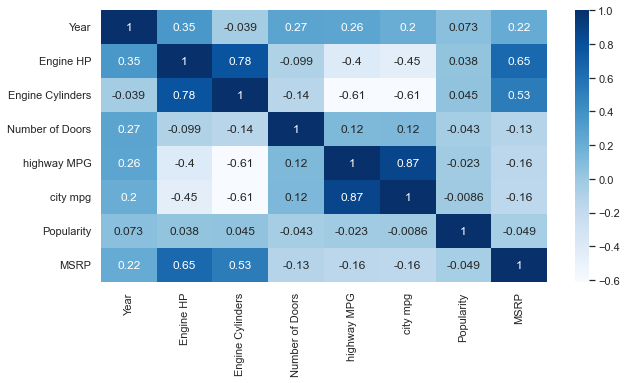

In [18]:
cor = train_df.corr()
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [19]:
expensive_categories = ["Luxury", "Performance", "Exotic"]
# figure(figsize=(8, 6), dpi=80)

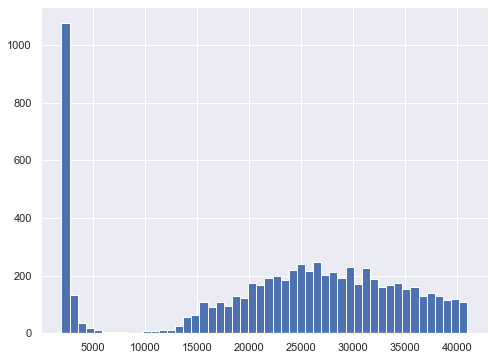

In [20]:
more_expensive = train_df[train_df["MSRP"] > 41000]
less_expensive = train_df[train_df["MSRP"] <= 41000]

# plt.hist(train_df["MSRP"], bins=100)
# train_df["MSRP"]
plt.figure(figsize=(8,6)) 
plt.hist(less_expensive["MSRP"], bins=50)
plt.show()

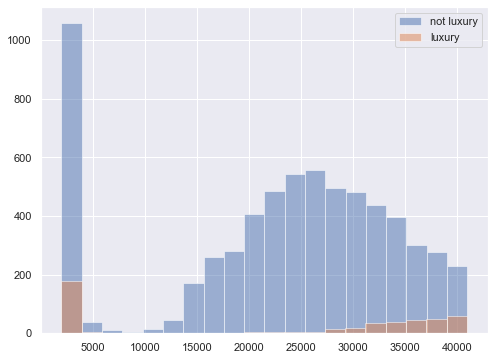

In [21]:
test = less_expensive.query("'Luxury' in `Market Category`")
test2 = less_expensive.query("'Luxury' not in `Market Category`")
plt.figure(figsize=(8, 6)) 
# plt.hist(less_expensive["MSRP"], bins=50, alpha=0.5)
plt.hist(test2["MSRP"], bins=20, alpha=0.5)
plt.hist(test["MSRP"], bins=20, alpha=0.5)
plt.legend(["not luxury", "luxury"])
plt.show()

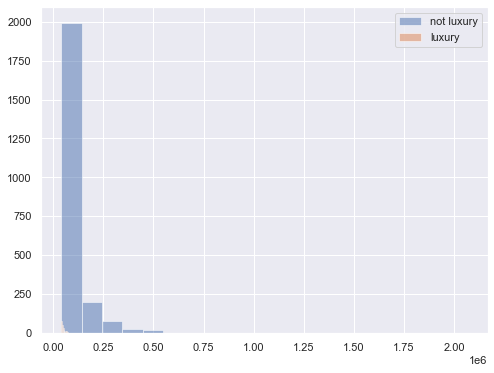

In [22]:
test3 = more_expensive.query("'Luxury' in `Market Category`")
test4 = more_expensive.query("'Luxury' not in `Market Category`")
plt.figure(figsize=(8, 6)) 
# plt.hist(less_expensive["MSRP"], bins=50, alpha=0.5)
plt.hist(test4["MSRP"], bins=20, alpha=0.5)
plt.hist(test3["MSRP"], bins=20, alpha=0.5)
plt.legend(["not luxury", "luxury"])
plt.show()

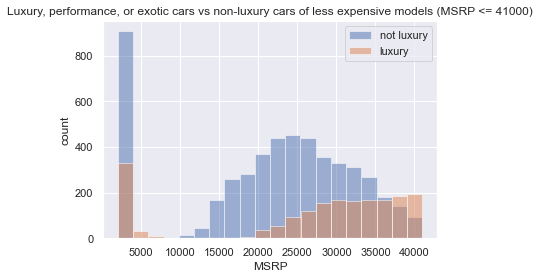

In [23]:
under_41000_data = {
    "Luxury, Performance, Exotic": [],
    "Other": [],
}
for index, row in less_expensive.iterrows():
    if "Luxury" in row["Market Category"] or "Performance" in row["Market Category"] or "Exotic" in row["Market Category"]:
        under_41000_data["Luxury, Performance, Exotic"].append(row["MSRP"])
    else:
        under_41000_data["Other"].append(row["MSRP"])
plt.hist(under_41000_data["Other"], bins=20, alpha=0.5)
plt.hist(under_41000_data["Luxury, Performance, Exotic"], bins=20, alpha=0.5)
plt.xlabel("MSRP")
plt.ylabel("count")
plt.title("Luxury, performance, or exotic cars vs non-luxury cars of less expensive models (MSRP <= 41000)")
plt.legend(["not luxury", "luxury"])
plt.show()

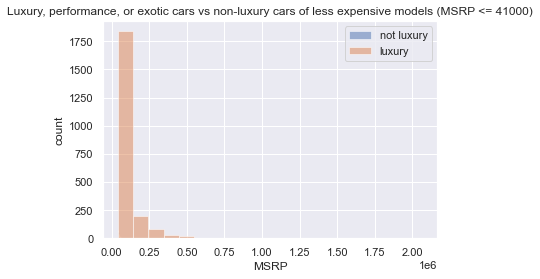

In [24]:
over_41000_data = {
    "Luxury, Performance, Exotic": [],
    "Other": [],
}
for index, row in more_expensive.iterrows():
    if "Luxury" in row["Market Category"] or "Performance" in row["Market Category"] or "Exotic" in row["Market Category"]:
        over_41000_data["Luxury, Performance, Exotic"].append(row["MSRP"])
    else:
        over_41000_data["Other"].append(row["MSRP"])
plt.hist(over_41000_data["Other"], bins=20, alpha=0.5)
plt.hist(over_41000_data["Luxury, Performance, Exotic"], bins=20, alpha=0.5)
plt.xlabel("MSRP")
plt.ylabel("count")
plt.title("Luxury, performance, or exotic cars vs non-luxury cars of less expensive models (MSRP <= 41000)")
plt.legend(["not luxury", "luxury"])
plt.show()